In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit, train_test_split, ShuffleSplit, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import time
from itertools import product
import matplotlib.pyplot as plt
from sklearn.multioutput import MultiOutputRegressor
from lightgbm import LGBMRegressor
import joblib  # 모델 저장을 위한 라이브러리

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False


In [4]:
def calculate_metrics(y_true, y_pred, training_time):
	"""평가 지표 계산 함수"""
	return {
		'MAE': mean_absolute_error(y_true, y_pred),
		'MSE': mean_squared_error(y_true, y_pred),
		'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
		'R2': r2_score(y_true, y_pred),
		'RMSLE': np.sqrt(mean_squared_error(np.log1p(y_true), np.log1p(y_pred))),
		'MAPE': np.mean(np.abs((y_true - y_pred) / y_true)) * 100,
		'Training_Time': training_time
	}

### 광어

In [18]:

def train_evaluate_lgbm_multistep(data, target_col='avgPrice', exclude_features=None, steps=28, time_series=True):
    """
    LightGBM 모델의 멀티스텝 예측 (다중 출력 모델) 학습 및 평가.
    
    Args:
        data (pd.DataFrame): 학습 데이터셋.
        target_col (str): 예측 대상 열 이름.
        exclude_features (list): 학습에 제외할 피처 리스트.
        steps (int): 예측할 시점 개수.
        time_series (bool): 타임 시리즈 데이터 여부.
    
    Returns:
        model: 학습된 멀티아웃풋 모델.
    """
    # 날짜 열을 datetime 형식으로 변환
    data['date'] = pd.to_datetime(data['date'])
    
    # 다중 출력 타겟 생성 (t+1, t+2, ..., t+steps)
    for step in range(1, steps + 1):
        data[f'{target_col}+{step}'] = data[target_col].shift(-step)
    data = data.dropna()  # NaN 값 제거
    
    # 입력 데이터와 다중 출력 타겟 설정
    X = data.drop(['date', 'item'] + [target_col] + [f'{target_col}+{i}' for i in range(1, steps + 1)], axis=1)
    y = data[[f'{target_col}+{i}' for i in range(1, steps + 1)]]
    
    # 특정 피처 제외 (exclude_features 리스트 기반)
    if exclude_features:
        X = X.drop(columns=exclude_features)
    
    # LightGBM 하이퍼파라미터 설정
    lgbm_params = {
        'n_estimators': 260,
        'max_depth': 8,
        'learning_rate': 0.1,
        'num_leaves': 9,
        'min_child_samples': 7,
        'subsample': 0.9,
        'colsample_bytree': 0.9,
        'random_state': 1030,
        'n_jobs': -1,
        'verbosity': -1 
    }
    
    # 교차 검증 방식 설정 (타임 시리즈 또는 무작위 분할)
    if time_series:
        test_size = len(X) // 10
        cv = TimeSeriesSplit(n_splits=5, test_size=test_size)
    else:
        from sklearn.model_selection import ShuffleSplit
        cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=1030)
    
    # MultiOutputRegressor로 멀티스텝 예측을 지원
    base_model = LGBMRegressor(**lgbm_params)
    multi_output_model = MultiOutputRegressor(base_model)
    
    # 모델 학습
    start_time = time.time()
    multi_output_model.fit(X, y)
    training_time = time.time() - start_time
    
    # 학습 시 사용된 피처 이름 저장
    joblib.dump(X.columns.tolist(), 'feature_names_multi.pkl')
    print("Feature names saved to 'feature_names_multi.pkl'")

    # 학습 시간 출력
    print(f"Training Time: {training_time:.2f} seconds")
    
    # 모델 예측
    y_pred = multi_output_model.predict(X)
    
    # 성능 평가 (RMSE, R2, MAE)
    rmse = np.sqrt(mean_squared_error(y, y_pred, multioutput='raw_values'))
    r2 = r2_score(y, y_pred, multioutput='variance_weighted')
    mae = mean_absolute_error(y, y_pred, multioutput='raw_values')
    
    print("\n** Model Performance **")
    print(f"RMSE (Per Step): {rmse}")
    print(f"R2 Score: {r2:.4f}")
    print(f"MAE (Per Step): {mae}")
    
    # 중요도 시각화
    feature_importances = np.mean([
        model.feature_importances_ for model in multi_output_model.estimators_
    ], axis=0)
    importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': feature_importances
    }).sort_values(by='Importance', ascending=False)
    
    print("\nFeature Importances:")
    print(importance_df)
    
    plt.figure(figsize=(10, 6))
    plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title('Feature Importances')
    plt.gca().invert_yaxis()  # 중요도가 높은 순으로 정렬
    plt.tight_layout()
    plt.show()
    
    # 학습된 모델 저장
    joblib.dump(multi_output_model, 'lgbm_multistep_model.joblib')
    print("\nModel saved as 'lgbm_multistep_model.joblib'")
    
    return multi_output_model




Feature names saved to 'feature_names_multi.pkl'
Training Time: 5.77 seconds

** Model Performance **
RMSE (Per Step): [ 985.41826785  979.03399802 1013.8568598  1012.39904738 1038.21817503
 1012.66923987 1026.9860792  1066.41446729 1092.3215094   805.9429611
  990.77193022  998.38205533 1035.52738159 1042.18901643 1108.86796506
  988.8965935   987.73594783 1004.90445881 1031.23403544  794.34291035
 1048.22283766  995.61028604 1007.94173809  997.92600774 1041.76748139
 1008.03648731 1090.34796414 1051.58923174]
R2 Score: 0.9581
MAE (Per Step): [692.94150719 683.40494843 702.90877648 699.13618883 719.56776595
 686.8569512  711.55911601 736.47982269 761.77451427 446.90407399
 690.75534077 683.8617579  711.06621558 712.19363185 764.21698025
 674.12499647 687.09554311 672.09146825 714.75737104 441.71619642
 741.93177485 690.7958934  692.72370131 675.60914696 710.96216322
 679.67713398 764.30220557 728.53890659]

Feature Importances:
             Feature  Importance
9     avgPrice_lag_1  26

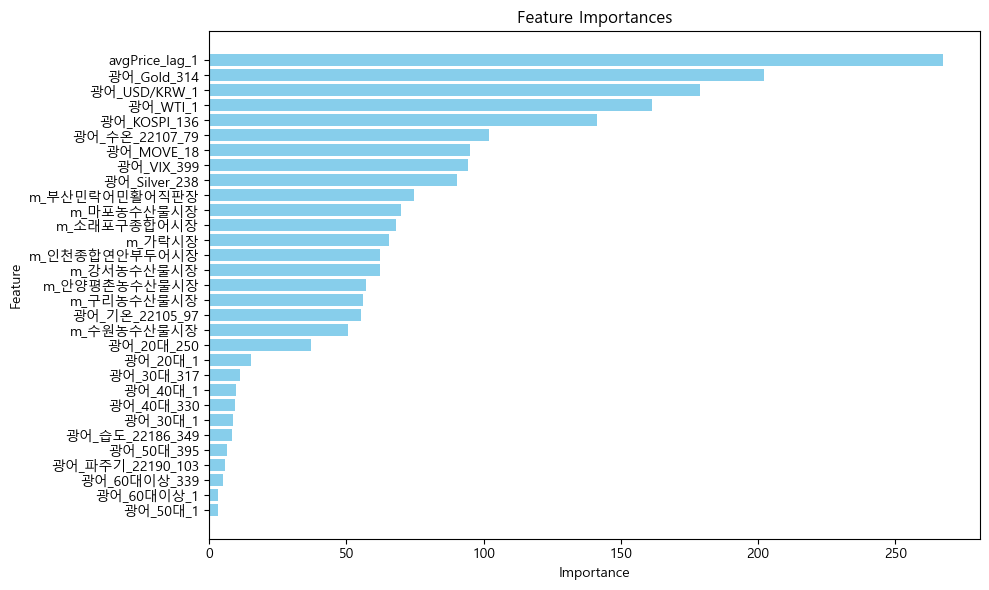


Model saved as 'lgbm_multistep_model.joblib'
MultiOutputRegressor(estimator=LGBMRegressor(colsample_bytree=0.9, max_depth=8,
                                             min_child_samples=7,
                                             n_estimators=260, n_jobs=-1,
                                             num_leaves=9, random_state=1030,
                                             subsample=0.9, verbosity=-1))

학습된 모델이 'lgbm_다중_광어.joblib'로 저장되었습니다.


In [19]:
# 데이터 로드 및 모델 학습 실행
data = pd.read_csv('../../../data/features/final_oneHot/광어_price_features_notnull.csv')
exclude_features = ['m_노량진시장']
model_다중_광어 = train_evaluate_lgbm_multistep(data, target_col='avgPrice', exclude_features=exclude_features, steps=28, time_series=True)
print(model_다중_광어)

# 학습된 모델 저장
joblib.dump(model_다중_광어, 'lgbm_다중_광어.joblib')  

print("\n학습된 모델이 'lgbm_다중_광어.joblib'로 저장되었습니다.")

### 가격 예측 

In [20]:
# 저장된 모델 로드
loaded_model = joblib.load('lgbm_다중_광어.joblib')
print("모델이 성공적으로 로드되었습니다.")

모델이 성공적으로 로드되었습니다.


In [30]:
def predict_future_by_market(data, model_path, start_date, columns_to_filter, steps=28):
    """
    학습된 모델로 시장별 미래 값을 예측.
    
    Args:
        data (pd.DataFrame): 예측에 사용할 입력 데이터.
        model_path (str): 학습된 모델 파일 경로.
        start_date (str): 예측 시작 날짜 (YYYY-MM-DD).
        columns_to_filter (list): 시장명을 나타내는 열 리스트.
        steps (int): 예측할 일 수 (기본값: 28).
    
    Returns:
        pd.DataFrame: 시장별 및 날짜별 예측 결과.
    """
    # 학습된 모델 로드
    model = joblib.load(model_path)

    # 저장된 피처 이름 로드
    feature_names = joblib.load('feature_names_multi.pkl')  # 학습 시 저장한 피처 리스트
    
    # 입력 데이터 전처리
    data['date'] = pd.to_datetime(data['date'])
    latest_data = data[data['date'] == pd.Timestamp(start_date)].copy()

    if latest_data.empty:
        raise ValueError(f"Start date {start_date} not found in the data.")
    
    # 결과 저장 리스트
    results = []

    # 각 시장별로 데이터 필터링 및 예측 수행
    for market in columns_to_filter:
        # 해당 시장 데이터 필터링
        market_data = latest_data[latest_data[market] == 1]
        if market_data.empty:
            continue  # 데이터가 없으면 건너뜀

        # 입력 데이터 준비 (특징만 사용)
        X_latest = market_data[feature_names]  # 학습 시 사용한 피처만 선택

        # 미래 값 예측
        future_predictions = model.predict(X_latest)  # (1, 28) 또는 (n, 28) 형식 반환

        # 결과 정리
        prediction_dates = [pd.Timestamp(start_date) + pd.Timedelta(days=i) for i in range(1, steps + 1)]
        for i in range(future_predictions.shape[0]):  # 샘플별로 처리
            for j, date in enumerate(prediction_dates):
                results.append({
                    'Market': market,
                    'Sample': i + 1,  # 샘플 인덱스
                    'Date': date,
                    'Predicted Price': future_predictions[i, j]
                })
    
    # 결과를 데이터프레임으로 변환
    prediction_df = pd.DataFrame(results)

    return prediction_df




In [33]:
# 데이터 로드
data = pd.read_csv('../../../data/features/final_oneHot/광어_price_features_notnull.csv')

# 2025년 1월 1일부터 28일 동안의 값 예측
model_path = 'lgbm_다중_광어.joblib'
start_date = '2024-12-31'
columns_to_filter = [
    "m_가락시장", "m_강서농수산물시장", "m_구리농수산물시장", "m_노량진시장",
    "m_마포농수산물시장", "m_부산민락어민활어직판장", "m_소래포구종합어시장", "m_수원농수산물시장",
    "m_안양평촌농수산물시장", "m_인천종합연안부두어시장"
]

# 예측 실행
predictions = predict_future_by_market(data, model_path, start_date, columns_to_filter, steps=28)

# 예측 결과 출력
print(predictions.to_string())

# # 특정 시장만 필터링
# filtered_predictions = predictions[predictions['Market'] == "m_가락시장"]
# print(filtered_predictions)

# # 특정 날짜만 필터링
# filtered_predictions = predictions[predictions['Date'] == '2025-01-01']
# print(filtered_predictions)

# 결과를 CSV 파일로 저장
predictions.to_csv('광어_predictions_by_market.csv', index=False)
print("결과가 '광어_predictions_by_market.csv'로 저장되었습니다.")


            Market  Sample       Date  Predicted Price
0           m_가락시장       1 2025-01-01     48005.818385
1           m_가락시장       1 2025-01-02     39987.335830
2           m_가락시장       1 2025-01-03     37992.300780
3           m_가락시장       1 2025-01-04     42851.889833
4           m_가락시장       1 2025-01-05     39337.987541
5           m_가락시장       1 2025-01-06     39622.144518
6           m_가락시장       1 2025-01-07     41415.030705
7           m_가락시장       1 2025-01-08     45082.586349
8           m_가락시장       1 2025-01-09     38523.809531
9           m_가락시장       1 2025-01-10     44849.000459
10          m_가락시장       1 2025-01-11     47834.985692
11          m_가락시장       1 2025-01-12     40074.488110
12          m_가락시장       1 2025-01-13     38274.605199
13          m_가락시장       1 2025-01-14     43895.564101
14          m_가락시장       1 2025-01-15     38645.954494
15          m_가락시장       1 2025-01-16     40087.592465
16          m_가락시장       1 2025-01-17     41167.519119
17        